# Text Classification: SVM Explained
Hello people! Welcome to this kernel. In this kernel I am going to develop a sentiment analyser using **Support Vector Machine** algorithm and **Bag of Words** representation.

Before starting, I have to say that: Using deep learning approachs such as **Recurrent Neural Networks** are better to classify texts, but when we have a small dataset, traditional machine learning may be good.

And if you interested in text classification with traditional machine learning, you might want to use a lazy algorithm to filter spam emails. If you, you can check my **Naive Bayes** kernel. In that kernel I've expalined everything (text processing and deploying a sklearn model included) detailed. Here is the link: https://www.kaggle.com/mehmetlaudatekman/filtering-spam-e-mails-power-of-naive-bayes

# Notebook Content
1. Preparing the Environment
    * Importing Libraries
    * Importing Datasets
1. Simply Explained: Support Vector Machine
1. Data Overview
    * Frequency Distributions with NLTK
1. Data Preprocessing
    * Cleaning Links
    * Cleaning Everything Except Alphabetical and Numerical Characters
    * Tokenizing and Lemmatizing
    * Removing Stopwords
    * Joining Prepared Strings
    * Bag of Words Approach
1. Support Vector Machine Classifier Modeling
    * Fitting SVMC Model with SKLearn
    * Testing Model
1. Conclusion


# Preparing the Environment
In this kernel, I will use **sklearn** to develop a model and vectorize the texts; **nltk** to preprocess texts and data overview.

And I will use several libraries.

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

In [7]:
train_set = pd.read_csv('./input/Corona_NLP_train.csv',encoding="latin1")
test_set = pd.read_csv('./input/Corona_NLP_test.csv',encoding="latin1")

train_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Simply Explained: Support Vector Machine
Support Vector Machine (after this I will say SVM) is a machine learning approach that has a classifier and regressor, in this section I will cover classifier.

There are versions of SVM such as Linear SVM. In linear SVM, model fits **N** lines to split classes from each other (N is class count - 1 ). We will say **Decision Lines** to these lines. 

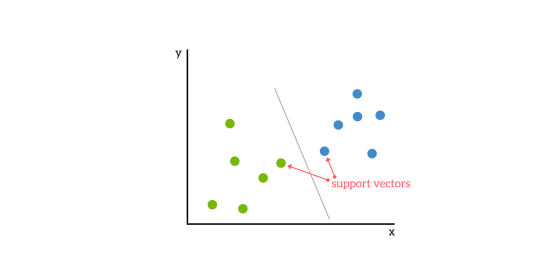

And in order to make classifier durable, **decision line** must be in the closest position to **support points** of each class.

I know, I have not explain what is support point. Support point (also support vectors) is the points that nearest to the decision line. You can see them in the graph above.

And sometimes our dataset may be non-linear. However we can still use SVM to classify non-linear dataset. In order to do this we'll use **kernel tricks**. If we add a new dimension to data we may classify it using lines. Let's take a look at the images below: (thanks for images, here is the link of article [in Turkish])

![](https://miro.medium.com/max/700/1*u7ogmOy2vQDjgw7Pou0hoA.png)

In this example we've added a new dimension (Z) to data and now we can classify it using a line.

Everything you need to know about basics of Support Vector Machine was this. Let's start to implement!

# Data Overview
In this section we will take a look at the data. And in order to do this we will use frequency distrubutions of NLTK.

* First let's drop unrelevant features

In [8]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


* Now let's split sentences as their class, Positive,Neutral and Negative.

In [9]:
train_set["Sentiment"].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [10]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()


Sentiment
Positive              11422
Extremely Positive     6624
Name: count, dtype: int64


,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive


In [11]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

Sentiment
Negative              9917
Extremely Negative    5481
Name: count, dtype: int64


,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
9,"For corona prevention,we should stop to buy th...",Negative
20,with 100 nations inficted with covid 19 th...,Extremely Negative
24,@10DowningStreet @grantshapps what is being do...,Negative
26,In preparation for higher demand and a potenti...,Negative


In [12]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

Sentiment
Neutral    7713
Name: count, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral


* Now let's convert labels into integers, I will label negatives as 0, neutrals as 1 and positives as 2.

In [13]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",0
9,"For corona prevention,we should stop to buy th...",0
20,with 100 nations inficted with covid 19 th...,0
24,@10DowningStreet @grantshapps what is being do...,0
26,In preparation for higher demand and a potenti...,0


* Now I will concatenate train and test, I will split them after processing.

In [14]:
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          44955 non-null  int64 
 1   OriginalTweet  44955 non-null  object
 2   Sentiment      44955 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [16]:
data.head()

,index,OriginalTweet,Sentiment
0,1,advice Talk to your neighbours family to excha...,2
1,2,Coronavirus Australia: Woolworths to give elde...,2
2,3,My food stock is not the only one which is emp...,2
3,5,As news of the regionÂs first confirmed COVID...,2
4,6,Cashier at grocery store was sharing his insig...,2


* Finally everything is ready, we can start examining data with examining random texts.

In [19]:
import random
for i in range(1,10):
    random_ind = random.randint(0,len(data))
    print(str(data["OriginalTweet"][random_ind]),end="\nLabel: ")
    print(str(data["Sentiment"][random_ind]),end="\n\n")


@BrexitBetrayed Disgusting ? and criminal!
Wasting food that will go bad/expired &amp; depriving many of getting some essential products and pushing prices up.
They might not catch the covid-19 but selfishnessvirus has caught them for sure.
Well, ca
Label: 0

https://t.co/IyTL2vnBZd Something to read
Label: 1

Amid all the real drama of #Covid_19, I no longer care to follow the latest #MeghanAndHarry stories. I am infinitely more worried about the health of my child and whether the supermarket will have anything left on the shelves when I get there. Bloody #doomsdaypreppers!! ?
Label: 0

ItÂs pathetic that it feels like winning the lottery when you go to the grocery store just as they are restocking the shelves with toilet paper, spring water or hand sanitizer. Thanks #Coronavirus
Label: 2

Just watched a critical care nurse crying on BBC News because when she gets to the supermarket the shelves are empty So if you re one of those selfish fucking stockpilers or profiteers just remembe

* And let's take a look at the frequency distributions.

In [20]:
positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

* And now we can examine most used words plots.

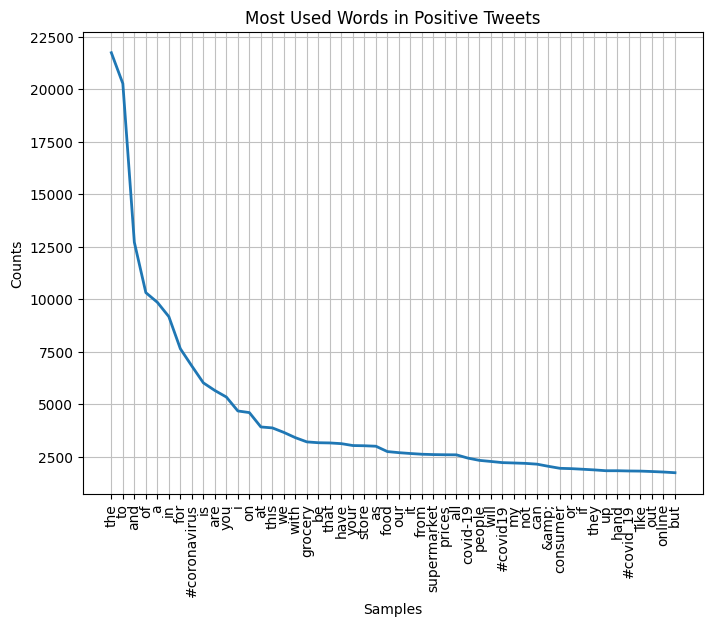

In [21]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

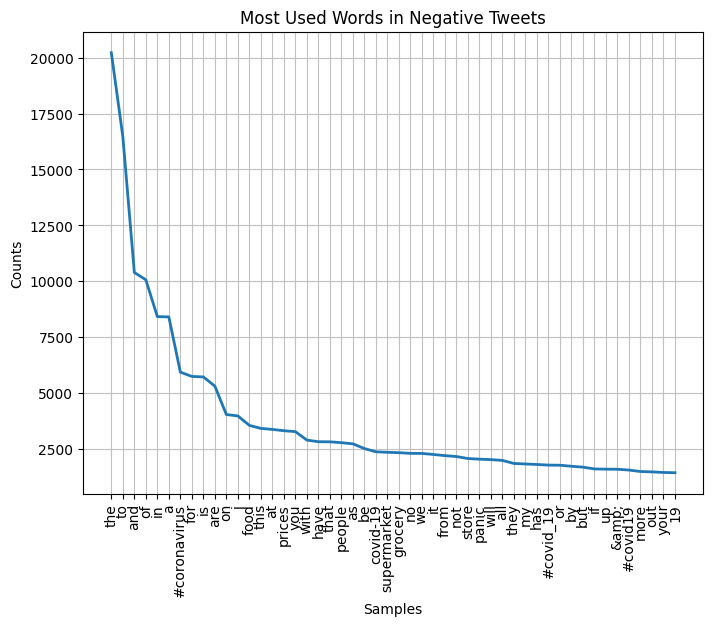

In [22]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

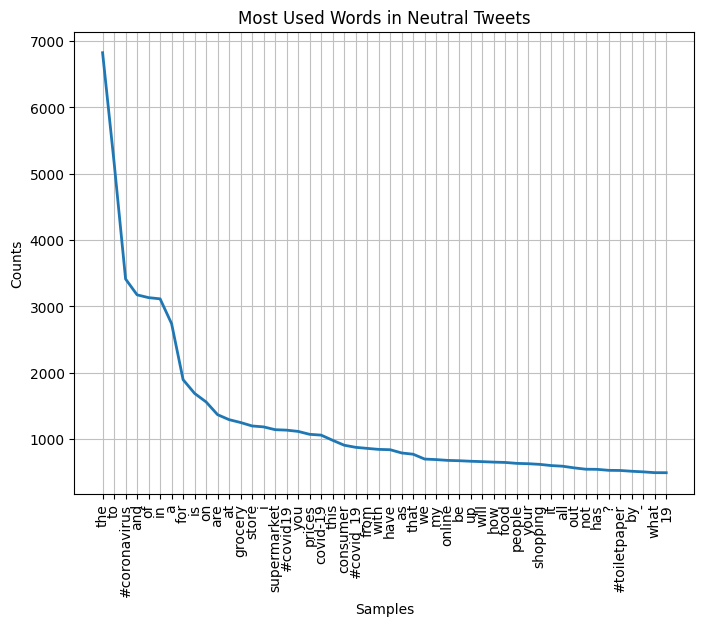

In [23]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Neutral Tweets")
neutralDF.plot(50)
plt.show()

* Although most of the words are same (we say them stopwords [words that not have a special meaning]) we can see characteristic words such as **panic**

# Data Preprocessing
In this section we will prepare the dataset in order to use in SVM model. Before starting I want to explain processes with 1 line explanations

* Cleaning Links: We'll clean all website links using regular expressions
* Cleaning Everything Except Alphabetical and Numerical Characters: We'll clean unrelevant digits using regular expressions
* Tokenizing and Lemmatizing: We'll split texts into their words and convert words to their base form (dogs=>dog)
* Removing Stopwords: We'll remove words that have no special meaning (such as **the,will,was**)
* Joining Prepared Strings: We'll join the words
* Bag of Words Approach: We'll create a bag of word. In bag of words approach each feature shows whether the text contains the word or not. For instance if our text contains **grocery** word, its **grocery** feature will be 1 if not it will be 0.

If you want to learn more detail about them, you can check my Naive Bayes text classification kernel. Here is the link: https://www.kaggle.com/mehmetlaudatekman/filtering-spam-e-mails-power-of-naive-bayes

In [36]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [37]:
for i in range(0,5):
    print(cleanedData[i],end="\n\n")

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account poss adequate supply regular med order

coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral

news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim dodson report

cashier grocery store wa sharing insight covid 19 prove credibility commented civics class know talking



* Now we can create our bag of words, but before starting I want to give an example:

        ====TEXT====           HELLO  WORLD  BRO  CLEAN  SOME  TEXT  WELCOME       
        Hello world               1     1     0     0      0     0      0 
        Hello bro                 1     0     1     0      0     0      0
        Clean some text           0     0     0     1      1     1      0
        You're welcome bro        0     0     1     0      0     0      1
        Welcome to world          0     1     0     0      0     0      1
        
This is a simple bag of words model. 

In [38]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)


* Everything is ready, we can split our set into train and test.

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


# Support Vector Machine Classifier Modeling
Everything is ready, now ve can fit our classifier.

In [40]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 870.6 seconds


* It took almost 13 minutes, I hope its worth it.

In [41]:
predictions = model.predict(x_test)

* Now let's take a look at the accuracy and confusion matrix.

In [44]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 76.5726488121719%


* Our accuracy is 77% Not bad, but I guess we can develop a better model using deep learning.

# Conclusion
Thanks for your attention. In this kernel I have explained what is SVM and how they work and developing a text classifier using SVMs.

If you have any question in your mind, please ask in comment section.

Have a great day!